This notebook uses the [Titanic dataset from Kaggle](https://www.kaggle.com/c/titanic/data?select=train.csv).

In [1]:
import datto as dt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from IPython.core.display import HTML, display
from sklearn.tree import DecisionTreeClassifier

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
✔ Linking successful
/Users/kristiewirth/.pyenv/versions/datto/lib/python3.7/site-packages/en_core_web_sm
-->
/Users/kristiewirth/.pyenv/versions/datto/lib/python3.7/site-packages/spacy/data/en
You can now load the model via spacy.load('en')


In [2]:
df = pd.read_csv('titanic.csv')

In [3]:
df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


In [4]:
eda = dt.Eda()

In [5]:
eda.sample_unique_vals(df)

PassengerId
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20]
891

------------------------------------

Survived
[0 1]
2

------------------------------------

Pclass
[3 1 2]
3

------------------------------------

Name
['Braund, Mr. Owen Harris'
 'Cumings, Mrs. John Bradley (Florence Briggs Thayer)'
 'Heikkinen, Miss. Laina' 'Futrelle, Mrs. Jacques Heath (Lily May Peel)'
 'Allen, Mr. William Henry' 'Moran, Mr. James' 'McCarthy, Mr. Timothy J'
 'Palsson, Master. Gosta Leonard'
 'Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)'
 'Nasser, Mrs. Nicholas (Adele Achem)' 'Sandstrom, Miss. Marguerite Rut'
 'Bonnell, Miss. Elizabeth' 'Saundercock, Mr. William Henry'
 'Andersson, Mr. Anders Johan' 'Vestrom, Miss. Hulda Amanda Adolfina'
 'Hewlett, Mrs. (Mary D Kingcome) ' 'Rice, Master. Eugene'
 'Williams, Mr. Charles Eugene'
 'Vander Planke, Mrs. Julius (Emelia Maria Vandemoortele)'
 'Masselmani, Mrs. Fatima']
891

------------------------------------

Sex
['male' 'female']
2

-

In [6]:
eda.find_cols_to_exclude(df)

{'Name': 'Considering excluding because object column has large number of unique values (891)'}
{'Ticket': 'Considering excluding because object column has large number of unique values (681)'}
{'Cabin': 'Considering excluding because 77.10437710437711% of column is null.'}


[{'Name': 'Considering excluding because object column has large number of unique values (891)'},
 {'Ticket': 'Considering excluding because object column has large number of unique values (681)'},
 {'Cabin': 'Considering excluding because 77.10437710437711% of column is null.'}]

In [7]:
eda.find_correlated_features(df)

Fare         Pclass         0.549500
Pclass       Fare           0.549500
SibSp        Parch          0.414838
Parch        SibSp          0.414838
Age          Pclass         0.369226
Pclass       Age            0.369226
Survived     Pclass         0.338481
Pclass       Survived       0.338481
Age          SibSp          0.308247
SibSp        Age            0.308247
Fare         Survived       0.257307
Survived     Fare           0.257307
Fare         Parch          0.216225
Parch        Fare           0.216225
             Age            0.189119
Age          Parch          0.189119
Fare         SibSp          0.159651
SibSp        Fare           0.159651
Age          Fare           0.096067
Fare         Age            0.096067
SibSp        Pclass         0.083081
Pclass       SibSp          0.083081
Parch        Survived       0.081629
Survived     Parch          0.081629
Age          Survived       0.077221
Survived     Age            0.077221
SibSp        PassengerId    0.057527
P

Fare         Pclass         0.549500
Pclass       Fare           0.549500
SibSp        Parch          0.414838
Parch        SibSp          0.414838
Age          Pclass         0.369226
Pclass       Age            0.369226
Survived     Pclass         0.338481
Pclass       Survived       0.338481
Age          SibSp          0.308247
SibSp        Age            0.308247
Fare         Survived       0.257307
Survived     Fare           0.257307
Fare         Parch          0.216225
Parch        Fare           0.216225
             Age            0.189119
Age          Parch          0.189119
Fare         SibSp          0.159651
SibSp        Fare           0.159651
Age          Fare           0.096067
Fare         Age            0.096067
SibSp        Pclass         0.083081
Pclass       SibSp          0.083081
Parch        Survived       0.081629
Survived     Parch          0.081629
Age          Survived       0.077221
Survived     Age            0.077221
SibSp        PassengerId    0.057527
P

In [8]:
ct = dt.CleanText()

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [10]:
df = ct.fix_col_data_type(df, 'Pclass', 'str')

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    object 
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(4), object(6)
memory usage: 83.7+ KB


In [12]:
dup_df = pd.DataFrame([[124, 124], [5676, 5676], [456, 456]], columns=['id', 'id'])
dup_df

,id,id
0,124,124
1,5676,5676
2,456,456


In [13]:
ct.remove_duplicate_columns(dup_df)

,id
0,124
1,5676
2,456


In [14]:
df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    object 
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(4), object(6)
memory usage: 358.5 KB


In [15]:
compressed_df = ct.compress_df(df)

In [16]:
compressed_df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   PassengerId  891 non-null    uint16  
 1   Survived     891 non-null    uint8   
 2   Pclass       891 non-null    category
 3   Name         891 non-null    object  
 4   Sex          891 non-null    category
 5   Age          714 non-null    float32 
 6   SibSp        891 non-null    uint8   
 7   Parch        891 non-null    uint8   
 8   Ticket       891 non-null    object  
 9   Fare         891 non-null    float32 
 10  Cabin        204 non-null    category
 11  Embarked     889 non-null    category
dtypes: category(4), float32(2), object(2), uint16(1), uint8(3)
memory usage: 158.7 KB


In [17]:
tm = dt.TrainModel()

In [18]:
train_df = compressed_df[['Survived', 'Pclass', 'Sex', 'Age', 'SibSp',
       'Parch', 'Fare', 'Embarked']]

In [19]:
dummies_df = pd.get_dummies(train_df)

In [20]:
dummies_df

,Survived,Age,SibSp,Parch,Fare,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,0,22.0,1,0,7.250000,0,0,1,0,1,0,0,1
1,1,38.0,1,0,71.283302,1,0,0,1,0,1,0,0
2,1,26.0,0,0,7.925000,0,0,1,1,0,0,0,1
3,1,35.0,1,0,53.099998,1,0,0,1,0,0,0,1
4,0,35.0,0,0,8.050000,0,0,1,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,0,27.0,0,0,13.000000,0,1,0,0,1,0,0,1
887,1,19.0,0,0,30.000000,1,0,0,1,0,0,0,1
888,0,NaN,1,2,23.450001,0,0,1,1,0,0,0,1
889,1,26.0,0,0,30.000000,1,0,0,0,1,1,0,0


In [21]:
filled_na_df = dummies_df.fillna(0).sample(100)

In [22]:
y = filled_na_df['Survived']
X = filled_na_df.drop('Survived', axis=1)

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [24]:
pipeline = Pipeline([("model", LogisticRegression()),])

tm.model_testing(X_train, y_train, pipeline, "classification", "precision", save_to_csv=False)

Fitting 3 folds for each of 62 candidates, totalling 186 fits


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  27 tasks      | elapsed:    2.4s





*** Best Parameters Using ['recall', 'precision', 'roc_auc'] | Tie Breaker: precision | 2021-03-22 15:03 ***
Params: {'model': DecisionTreeClassifier(), 'model__max_depth': 5, 'model__min_samples_split': 0.5}
Mean Recall: 0.7926
Mean Precision: 0.6714
Mean ROC AUC: 0.7947


Params: {'model': DecisionTreeClassifier(), 'model__max_depth': 5, 'model__min_samples_split': 1.0}
Mean Recall: 0.7926
Mean Precision: 0.7021
Mean ROC AUC: 0.7880


Params: {'model': DecisionTreeClassifier(), 'model__max_depth': 10, 'model__min_samples_split': 0.5}
Mean Recall: 0.7926
Mean Precision: 0.6714
Mean ROC AUC: 0.7947


Params: {'model': DecisionTreeClassifier(), 'model__max_depth': 10, 'model__min_samples_split': 1.0}
Mean Recall: 0.7926
Mean Precision: 0.7021
Mean ROC AUC: 0.7880


Params: {'model': DecisionTreeClassifier(), 'model__max_depth': 15, 'model__min_samples_split': 0.5}
Mean Recall: 0.7926
Mean Precision: 0.6714
Mean ROC AUC: 0.7947


Params: {'model': DecisionTreeClassifier(), 'model__max

[Parallel(n_jobs=-2)]: Done 186 out of 186 | elapsed:    7.8s finished


{'model': XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
               colsample_bynode=None, colsample_bytree=None, gamma=None,
               gpu_id=None, importance_type='gain', interaction_constraints=None,
               learning_rate=0.001, max_delta_step=None, max_depth=None,
               min_child_weight=None, missing=nan, monotone_constraints=None,
               n_estimators=5, n_jobs=None, num_parallel_tree=None,
               random_state=None, reg_alpha=None, reg_lambda=None,
               scale_pos_weight=None, subsample=None, tree_method=None,
               validate_parameters=None, verbosity=None),
 'model__learning_rate': 0.001,
 'model__n_estimators': 5}

In [25]:
mr = dt.ModelResults()

In [26]:
model = DecisionTreeClassifier(max_depth=5, min_samples_split=1.0)
model.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=5, min_samples_split=1.0)

100%|██████████| 25/25 [00:00<00:00, 194.25it/s]


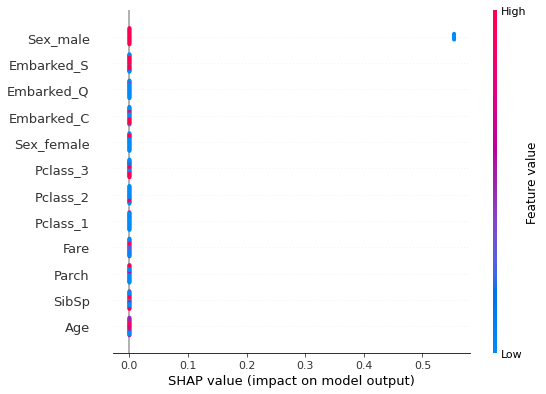

array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.55411255, 0.        ,
        0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.55411255, 0.        ,
        0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        ,

<Figure size 432x288 with 0 Axes>

In [28]:
mr.coefficients_graph(X_train, X_test, model, 'classification', 'shap_test.png')

In [29]:
topic_words_df, combined_df = mr.most_similar_texts(df, 10, 'Name', 5)
topic_words_df

Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['-pron-', 'make'] not in stop_words.


Topics created with top words & example texts:
   topic_num  num_in_category  \
0          0              406   
1          1              192   
2          2              120   
3          3               68   
4          4              105   

                               top_words_and_phrases  \
0  [miss, mary, miss mary, annie, helen, anna, el...   
1  [mrs, mrs william, mary, elizabeth, joseph, sa...   
2  [william, mr william, mrs william, henry, jame...   
3  [john, mr john, henry, mrs john, george, jr, d...   
4  [master, george, rice, panula, leonard, henry,...   

                                            example0  \
0                             Heikkinen, Miss. Laina   
1                            Braund, Mr. Owen Harris   
2                           Allen, Mr. William Henry   
3  Cumings, Mrs. John Bradley (Florence Briggs Th...   
4                     Palsson, Master. Gosta Leonard   

                                       example1  \
0               Sandstrom, Mi

,topic_num,num_in_category,top_words_and_phrases,example0,example1,example2,example3,example4,example5,example6,example7,example8,example9
0,0,406,"[miss, mary, miss mary, annie, helen, anna, el...","Heikkinen, Miss. Laina","Sandstrom, Miss. Marguerite Rut","Bonnell, Miss. Elizabeth","Vestrom, Miss. Hulda Amanda Adolfina","Beesley, Mr. Lawrence","McGowan, Miss. Anna ""Annie""","Palsson, Miss. Torborg Danira","Emir, Mr. Farred Chehab","O'Dwyer, Miss. Ellen ""Nellie""","Todoroff, Mr. Lalio"
1,1,192,"[mrs, mrs william, mary, elizabeth, joseph, sa...","Braund, Mr. Owen Harris","Futrelle, Mrs. Jacques Heath (Lily May Peel)","McCarthy, Mr. Timothy J","Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)","Nasser, Mrs. Nicholas (Adele Achem)","Hewlett, Mrs. (Mary D Kingcome)","Williams, Mr. Charles Eugene","Vander Planke, Mrs. Julius (Emelia Maria Vande...","Masselmani, Mrs. Fatima","Fynney, Mr. Joseph J"
2,2,120,"[william, mr william, mrs william, henry, jame...","Allen, Mr. William Henry","Moran, Mr. James","Saundercock, Mr. William Henry","Sloper, Mr. William Thompson","Spencer, Mrs. William Augustus (Marie Eugenie)","Cann, Mr. Ernest Charles","Rogers, Mr. William John","Crease, Mr. Ernest James","Ford, Mr. William Neal","Slocovski, Mr. Selman Francis"
3,3,68,"[john, mr john, henry, mrs john, george, jr, d...","Cumings, Mrs. John Bradley (Florence Briggs Th...","Holverson, Mr. Alexander Oskar","Turpin, Mrs. William John Robert (Dorothy Ann ...","Harris, Mr. Henry Birkhardt","Hood, Mr. Ambrose Jr","Moen, Mr. Sigurd Hansen","Dean, Mr. Bertram Frank","Doling, Mrs. John T (Ada Julia Bone)","Barton, Mr. David John","Cribb, Mr. John Hatfield"
4,4,105,"[master, george, rice, panula, leonard, henry,...","Palsson, Master. Gosta Leonard","Andersson, Mr. Anders Johan","Rice, Master. Eugene","Panula, Master. Juha Niilo","Nosworthy, Mr. Richard Cater","Goodwin, Master. William Frederick","Skoog, Master. Harald","Moubarek, Master. Gerios","Caldwell, Master. Alden Gates","Goldschmidt, Mr. George B"


In [30]:
pipeline = Pipeline([("model", DecisionTreeClassifier(max_depth=5, min_samples_split=1.0))])

pipeline.fit(X_train, y_train)
y_predicted = pipeline.predict(X_test)

mr = dt.ModelResults()
mr.score_final_model(
    "classification", X_train, y_train, X_test, y_test, pipeline
)

Final Model Precision: 0.5714285714285714
Final Model Recall: 0.5714285714285714
Final Model Accuracy: 0.76
Final Model ROC AUC: 0.7023809523809523
Predicted   0  1
Actual          
0          15  3
1           3  4
Predicted     0     1
Actual               
0          0.60  0.12
1          0.12  0.16


(Pipeline(steps=[('model',
                  DecisionTreeClassifier(max_depth=5, min_samples_split=1.0))]),
 array([0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0,
        0, 0, 0], dtype=uint8))

In [31]:
example1 = """I am some text with a link in it: https://www.google.com Sincerely Kristie"""

In [32]:
ct.remove_links(example1)

'I am some text with a link in it:  Sincerely Kristie'

In [33]:
example2 = """I enjoy reading and meditating. Yesterday I made a quiche."""

In [34]:
ct.lematize(example2)

['-PRON-',
 'enjoy',
 'read',
 'and',
 'meditating',
 '.',
 'yesterday',
 '-PRON-',
 'make',
 'a',
 'quiche',
 '.']

In [35]:
example3 = """
Dear so & so, 

I have a question for you. 

Sincerely, Kristie"""

In [36]:
ct.remove_email_greetings_signatures(example3)

'\n\n\nI have a question for you. \n\n'

In [37]:
df = ct.clean_column_names(df)

In [38]:
fe = dt.FrontEnd()

In [39]:
dropdown_html = fe.dropdown_from_dataframe('Count of Siblings', df, 'sibsp')

In [40]:
display(HTML(dropdown_html))

In [41]:
tm.model_testing(X_train, y_train, pipeline, "classification", "precision", save_to_csv=False)

Fitting 3 folds for each of 62 candidates, totalling 186 fits


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  40 tasks      | elapsed:    0.9s





*** Best Parameters Using ['recall', 'precision', 'roc_auc'] | Tie Breaker: precision | 2021-03-22 15:03 ***
Params: {'model': DecisionTreeClassifier(), 'model__max_depth': 5, 'model__min_samples_split': 0.5}
Mean Recall: 0.7926
Mean Precision: 0.6714
Mean ROC AUC: 0.7947


Params: {'model': DecisionTreeClassifier(), 'model__max_depth': 5, 'model__min_samples_split': 1.0}
Mean Recall: 0.7926
Mean Precision: 0.7021
Mean ROC AUC: 0.7880


Params: {'model': DecisionTreeClassifier(), 'model__max_depth': 10, 'model__min_samples_split': 0.5}
Mean Recall: 0.7926
Mean Precision: 0.6714
Mean ROC AUC: 0.7947


Params: {'model': DecisionTreeClassifier(), 'model__max_depth': 10, 'model__min_samples_split': 1.0}
Mean Recall: 0.7926
Mean Precision: 0.7021
Mean ROC AUC: 0.7880


Params: {'model': DecisionTreeClassifier(), 'model__max_depth': 15, 'model__min_samples_split': 0.5}
Mean Recall: 0.7926
Mean Precision: 0.6714
Mean ROC AUC: 0.7947


Params: {'model': DecisionTreeClassifier(), 'model__max

[Parallel(n_jobs=-2)]: Done 186 out of 186 | elapsed:    6.6s finished


{'model': XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
               colsample_bynode=None, colsample_bytree=None, gamma=None,
               gpu_id=None, importance_type='gain', interaction_constraints=None,
               learning_rate=0.001, max_delta_step=None, max_depth=None,
               min_child_weight=None, missing=nan, monotone_constraints=None,
               n_estimators=5, n_jobs=None, num_parallel_tree=None,
               random_state=None, reg_alpha=None, reg_lambda=None,
               scale_pos_weight=None, subsample=None, tree_method=None,
               validate_parameters=None, verbosity=None),
 'model__learning_rate': 0.001,
 'model__n_estimators': 5}